## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import time
from tqdm import tqdm

from scripts.solvers.qkp_solver import *
from scripts.utils.kp_utils import *
from ADMM.scripts.solvers.classical_solver_UC import gurobi_knapsack_solver
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Pauli
from qiskit.transpiler.passes.optimization.light_cone import LightCone
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.utils.remove_barriers import RemoveBarriers
from qiskit.transpiler import PassManager
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp

### Generate problem instances

In [ ]:
from pathlib import Path

def load_instance(file_path: str):
    file_path = str(file_path)
    with open(file_path, "r") as f:
        lines = f.readlines()

    n = int(lines[0].strip())  # Number of items
    items = [tuple(map(int, line.strip().split())) for line in lines[1:n+1]]  # value, weight
    capacity = int(lines[n+1].strip())  # Knapsack capacity

    values = [v for v, w in items]
    weights = [w for v, w in items]

    return {
        "file": file_path,
        "num_items": n,
        "values": values,
        "weights": weights,
        "capacity": capacity
    }
def load_first_n_nap_instances(folder_path: str, n: int = 10):
    folder = Path(folder_path)
    # Get all .NAP files (case-sensitive); use case-insensitive match if needed
    instance_files = list(folder.glob("*.knp"))[:n]

    instances = []
    for file_path in instance_files:
        instance = load_instance(file_path)
        instances.append(instance)

    return instances

def load_first_n_nap_instances(folder_path: str, n: int = 10):
    folder = Path(folder_path)
    # Get all .NAP files (case-sensitive); use case-insensitive match if needed
    instance_files = list(folder.glob("*.knap"))[:n]

    instances = []
    for file_path in instance_files:
        instance = load_instance(file_path)
        instances.append(instance)

    return instances
def generate_profit(n,d,frac):
    weights = np.random.randint(1, 1001, n)
    values = d * np.ceil(weights / d).astype(int)
    capacity = frac * np.sum(weights)
    return values, weights,capacity

def generate_random_ratio(n, frac,ratio_range = 0.005):
    weights = np.random.randint(300, 1001, n)
    ratios = np.random.uniform(1- ratio_range, 1, n)
    # ratios = np.random.normal(1, ratio_range, n)
    values = weights * ratios
    capacity = frac * np.sum(weights)
    return  values,weights,capacity

def generate_inversely_strongly_correlated(n,frac):
    values = np.random.randint(1, 1001, n)
    weights = values + np.random.choice([98, 102], n)
    capacity = frac * np.sum(weights)
    return values, weights, capacity

def get_knapsack_instance(
     profit=False,
    inversely_strongly_correlated=False,
    random_ratio=False,
    use_hard_data=False,# relevant when use_hard_data=True
    real_dataset_name="Hard",# relevant when use_hard_data=True
    num_hard_instances=20,# relevant when use_hard_data=True
    instance_index= 13, # relevant when use_hard_data=True 13 for 100 items,12 for 50 items
    n=100,
    d=3,
    frac=0.09
):
    """
    Load or generate a knapsack problem instance.

    Parameters:
    - use_real_data: If True, load real instance; otherwise, generate synthetic.
    - real_dataset_name: Name of the dataset to load real instances from.
    - instance_index: Index of the instance to select from loaded instances.
    - num_hard_instances: How many real instances to load.
    - n: Number of items (used only when generating synthetic instances).
    - d: Parameter for `generate_profit` (used when generating synthetic).
    - frac: Fraction of total weight used to set capacity.
    - use_random_ratio: If True, use `generate_random_ratio`; otherwise use `generate_profit`.

    Returns:
    - n: Number of items
    - weights: np.ndarray of item weights
    - values: np.ndarray of item values
    - capacity: Capacity of the knapsack
    - frac: Capacity as a fraction of total weight
    """

    if use_hard_data:
        print('hard data')
        instances = load_first_n_nap_instances(real_dataset_name, num_hard_instances)
        instance = instances[instance_index]
        n = instance['num_items']
        print('number of item',n)
        weights = np.array(instance['weights'])
        values = np.array(instance['values'])
       # print('weights',weights)
        capacity = np.array(instance['capacity'])
        frac = capacity / np.sum(weights)
        print('frac',frac)
    elif inversely_strongly_correlated:
        print('inversely_strongly_correlated')
        values, weights,capacity = generate_inversely_strongly_correlated(n,frac)
        capacity=frac*np.sum(weights)
        print('frac',frac)
    elif profit:
        print('profit')
        print('frac',frac)
        values, weights,capacity = generate_profit(n, d, frac)
        weights = np.array(weights)
        values = np.array(values)
        capacity=frac*np.sum(weights)
    elif random_ratio:
        print('random ratio')
        print('frac',frac)
        values, weights,capacity = generate_random_ratio(n, frac)
        weights = np.array(weights)
        values = np.array(values)
        capacity=frac*np.sum(weights)
        #print('weights',weights) 
    else:
        raise ValueError("Must specify one of the instance generation.")  
    return n, weights, values, capacity, frac

In [ ]:
n, weights, values, capacity, frac= get_knapsack_instance(
    profit=False,
    inversely_strongly_correlated=True,
    random_ratio=False,
    use_hard_data=True,# relevant when use_hard_data=True
    real_dataset_name="Hard",# relevant when use_hard_data=True
    num_hard_instances=12,# relevant when use_hard_data=True
    instance_index= 10, # 
    n=100,
    d=3,
    frac=0.09
)

In [111]:
print(values)
print(weights)
print(frac)

[429.8321853  472.59543497 397.89707825 327.211258   408.94496154
 420.71575349 475.98250016 383.11683338 436.30252916 312.08036162
 432.41225659 458.29188882 418.93390391 319.16645198 343.93498423
 309.67757943 445.66519501 465.51550777 330.79502382 455.86915142
 381.15862739 345.71558713 386.54876891 381.51730018 352.6930385
 360.69840158 397.1748372  454.14578607 426.51667133 485.13751844
 469.95010633 362.71339135 443.66153906 355.68864682 377.07339115
 418.78092644 462.9326837  370.2020754  423.50321082 419.31075461
 477.16543363 299.98166407 438.1917573  339.93055435 323.02740899
 317.3637021  359.43547402 466.37017943 330.21835016 419.22442832
 431.244682   418.46886587 395.93284519 335.43192765 389.76914058
 313.95303913 367.62588951 442.58638142 461.51888039 372.08145377
 310.34786324 389.56740531 416.08764623 412.98404269 382.25200491
 378.52892627 306.29289608 311.32556828 488.52657219 344.76854312
 483.23538544 353.55918082 329.09126351 333.19425544 326.27908807
 332.935978

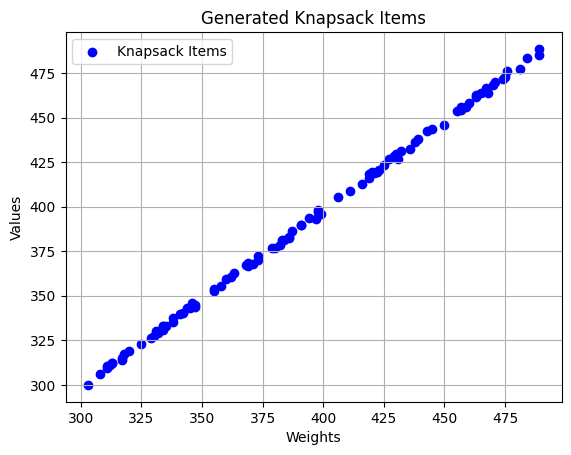

In [ ]:
# from collections import Counter

# n = 100  # Number of items
# frac = 0.3 # Fraction of total weight to set as capacity

# def generate_random_ratio(n, ratio_range = 0.005):
#     weights = np.random.randint(300, 500, n)
#     ratios = np.random.uniform(1- ratio_range, 1, n)
#     values = weights * ratios
#     return weights, values

# [weights,values] = generate_random_ratio(n, ratio_range=0.01) # create the list of knapsack items

# capacity = frac * np.sum(weights)  # Set weight limit to some % of total weight

# Plot the knapsack items
plt.scatter(weights, values, color='blue', marker='o', label='Knapsack Items')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

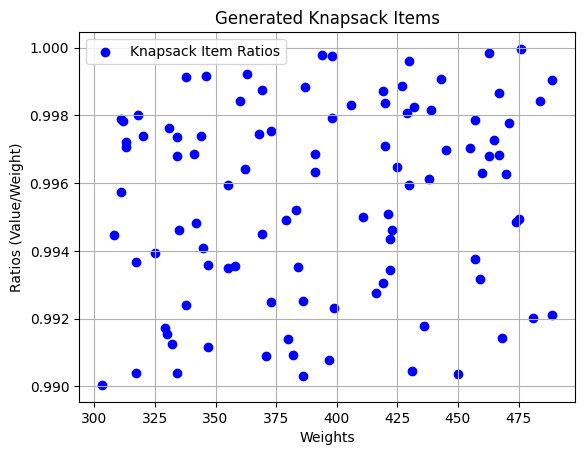

In [6]:
ratios = values / weights
plt.scatter(weights, ratios, color='blue', marker='o', label='Knapsack Item Ratios')
plt.title('Generated Knapsack Items')
plt.xlabel('Weights')
plt.ylabel('Ratios (Value/Weight)')
plt.legend()
plt.grid(True)
plt.show()

Now lets solve the problem with Gurobi and plot the optimal solution.

Restricted license - for non-production use only - expires 2026-11-23
Knapsack Capacity: 11811.0
Total Value of optimal solution: 11795.129911249609
Total Weight of optimal solution: 11811
Runtime: 0.028282 seconds


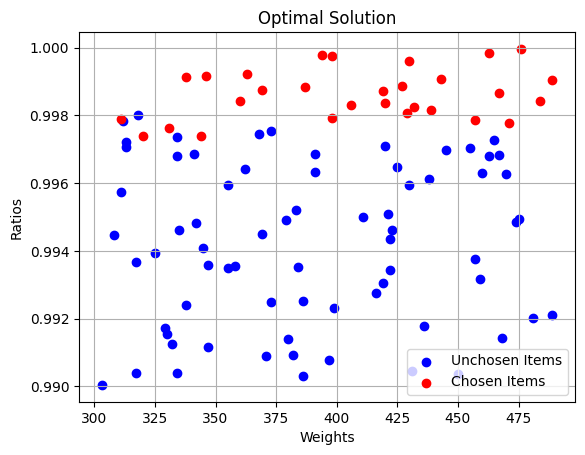

In [7]:
# Solve the knapsack problem using Gurobi
result_gurobi = gurobi_knapsack_solver(values, weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

print(f"Knapsack Capacity: {capacity}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

As a sanity check, lets construct the greedy solution and see how it compares to Gurobi. 

Greedy Solution Value: 11761.550390502427
Greedy Solution Weight: 11777


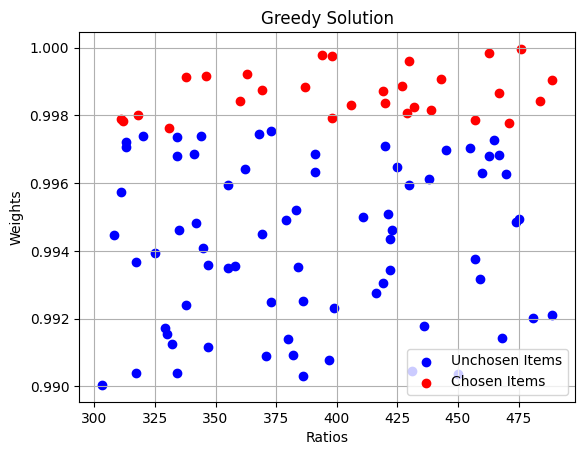

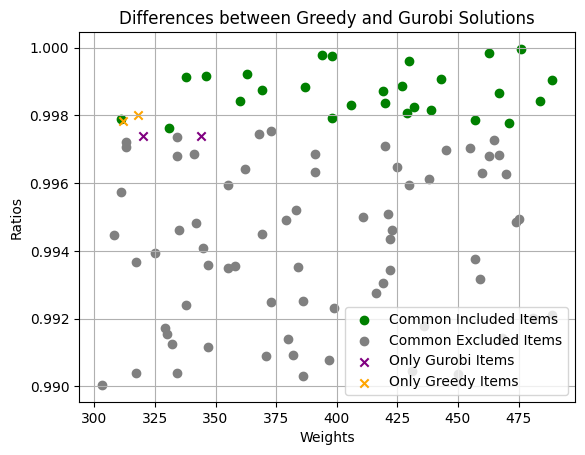

Gurobi solution obtains a value 33.5795 above the greedy solution.
This corresponds to greedy being a fraction 0.0028 off optimal.


In [8]:
greedy_weight = 0
greedy_solution = np.zeros(n, dtype=bool)

# Order items by their ratio with weight as the tiebreaker
greedy_order = np.lexsort((-weights, -ratios))

for i in greedy_order:
    if greedy_weight + weights[i] <= capacity:
        greedy_solution[i] = True
        greedy_weight += weights[i]
    
greedy_value = np.sum(values[greedy_solution])
print(f"Greedy Solution Value: {greedy_value}")
print(f"Greedy Solution Weight: {greedy_weight}")
# Plot the greedy solution
plt.figure()
plt.scatter(weights[~greedy_solution], ratios[~greedy_solution], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[greedy_solution], ratios[greedy_solution], color='red', marker='o', label='Chosen Items')
plt.title('Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

# Plot the indices where the greedy solution and Gurobi solution differ
diff_indices = np.logical_xor(greedy_solution, soln_mask)
diff_gurobi_solutions = np.logical_and(soln_mask, diff_indices)
diff_greedy_solutions = np.logical_and(greedy_solution, diff_indices)
common_solutions = np.logical_and(greedy_solution, soln_mask)
common_excluded = np.logical_and(~greedy_solution, ~soln_mask)
plt.figure()
plt.scatter(weights[common_solutions], ratios[common_solutions], color='green', marker='o', label='Common Included Items')
plt.scatter(weights[common_excluded], ratios[common_excluded], color='gray', marker='o', label='Common Excluded Items')
plt.scatter(weights[diff_gurobi_solutions], ratios[diff_gurobi_solutions], color='purple', marker='x', label='Only Gurobi Items')
plt.scatter(weights[diff_greedy_solutions], ratios[diff_greedy_solutions], color='orange', marker='x', label='Only Greedy Items')
plt.title('Differences between Greedy and Gurobi Solutions')
plt.xlabel('Weights')
plt.ylabel('Ratios')
plt.legend()
plt.grid(True)
plt.show()

print(f"Gurobi solution obtains a value {optimal_value - greedy_value:.4f} above the greedy solution.")
print(f"This corresponds to greedy being a fraction {(optimal_value - greedy_value)/optimal_value:.4f} off optimal.")


## Quantum Solution

### Classical Warm Start Distribution

Our starting point for the Quantum Solution is a classical warm start. 

To understand this distribution we first construct the "lazy greedy" classical solution. This is obtained similarly to the greedy classical solution constructed above, only the algorithm stops when it encounters the first item that doesn't fit into the knapsack.

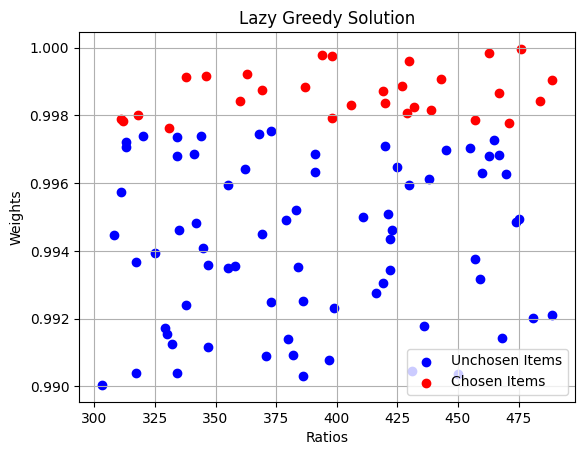

In [9]:
def construct_lazy_greedy_solution(weights, ratios, capacity):
    # Constructs a lazy greedy solution
    lazy_greedy_weight = 0
    lazy_greedy_solution = np.zeros(n, dtype=bool)

    # Order items by their ratio with weight as the tiebreaker
    greedy_order = np.lexsort((-weights, -ratios))

    for i in greedy_order:
        if lazy_greedy_weight + weights[i] <= capacity:
            lazy_greedy_solution[i] = True
            lazy_greedy_weight += weights[i]
        else:
            break
    return lazy_greedy_solution

lgs = construct_lazy_greedy_solution(weights, ratios, capacity)
plt.figure()
plt.scatter(weights[~lgs], ratios[~lgs], color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[lgs], ratios[lgs], color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Weights')
plt.legend()
plt.grid(True)
plt.show()



This solution will never be better than the greedy solution visualized above, but it does give us a useful starting point for constructing our warm start distribution. 

As a first step, notice that if we sort items by ratio of (value/weight) the lazy greedy distribution has a cutoff above which all items are included in the solution, and below which items are excluded. 

In the next plot we visualize this as giving a `probability' (either 0 or 1) of being included in the lazy greedy solution. This is to prepare us for the warm start distribution, which we define next. 



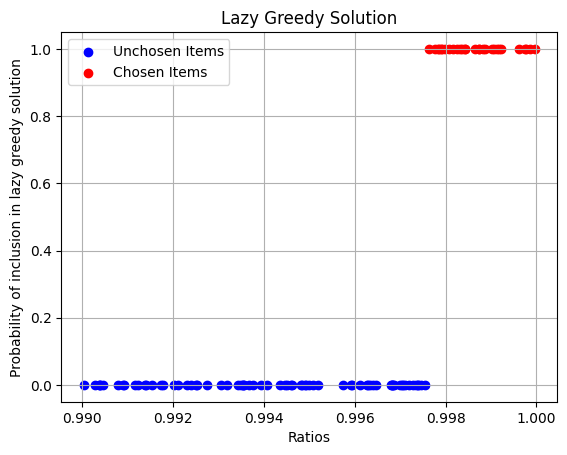

In [10]:
plt.figure()
plt.scatter(ratios[~lgs], np.zeros_like(values[~lgs]), color='blue', marker='o', label='Unchosen Items')
plt.scatter(ratios[lgs], np.ones_like(values[lgs]), color='red', marker='o', label='Chosen Items')
plt.title('Lazy Greedy Solution')
plt.xlabel('Ratios')
plt.ylabel('Probability of inclusion in lazy greedy solution')
plt.legend()
plt.grid(True)
plt.show()

Our warm start distribution can now be obtained by "smoothing out" the above probabilities slightly. It is defined in terms of an inverse temperature parameter k. Setting k = infinity produces the lazy greedy distribution above, while setting k = 0 produces a uniform distribution with expected weight equal to the capacity of knapsack. 

0.997638520106743
0.997638520106743
0.997638520106743
0.997638520106743
0.997638520106743
0.997638520106743
0.997638520106743
0.997638520106743


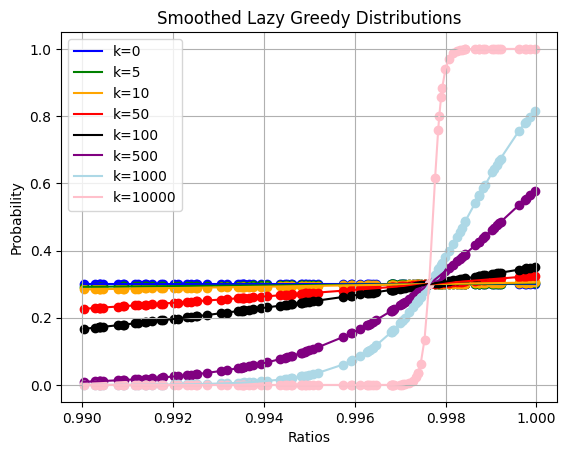

In [103]:

def construct_smoothed_lazy_greedy_distribution(weights, values, capacity, inv_temp):
    # First find the cutoff ratio for the lazy greedy solution.
    lazy_greedy_solution = construct_lazy_greedy_solution(weights, values / weights, capacity)
    cutoff_ratio = np.min(ratios[lazy_greedy_solution]) 
    print( cutoff_ratio)
    # Then set some constants so that in the limit of k = 0 we have the correct uniform distribution.
    uniform_probability = np.sum(weights) / capacity
    #print('uniform prob', 1 / (1 + (uniform_probability - 1)))
    return 1 / (1 + (uniform_probability - 1) * np.exp(-inv_temp * (ratios - cutoff_ratio)))

# Lets plot some solutions for different values of k
k_values = [0,5, 10,50, 100,500, 1000,10000]
colours = ['blue', 'green', 'orange', 'red','k', 'purple','lightblue', 'pink']
plt.figure()
for i in range(len(k_values)):
    smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k_values[i])
    plt.scatter(ratios, smoothed_distribution, color=colours[i], marker='o')
    # plot a line through the points
    ordered_indices = np.argsort(ratios)
    plt.plot(ratios[ordered_indices], smoothed_distribution[ordered_indices], color=colours[i], label=f'k={k_values[i]}')
plt.title('Smoothed Lazy Greedy Distributions')
plt.xlabel('Ratios')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


Note that our "solution" is now a probability distribution. We can repeatedly sample from this distribution to understand the quality of the solutions our warm start gives. An important observation is that this distribution will sometimes give solutions which do not respect the capacity restraints of thte knapsack. We must filter those out to get an accurate understanding of the solution quality.  

Best valid solution value is: 11749.015993649115
Worst invalid solution is: 12007.348359748046
Optimal solution value is: 11795.129911249609
Probability of valid samples: 0.996
Approximation ratio of valid samples: 0.6828


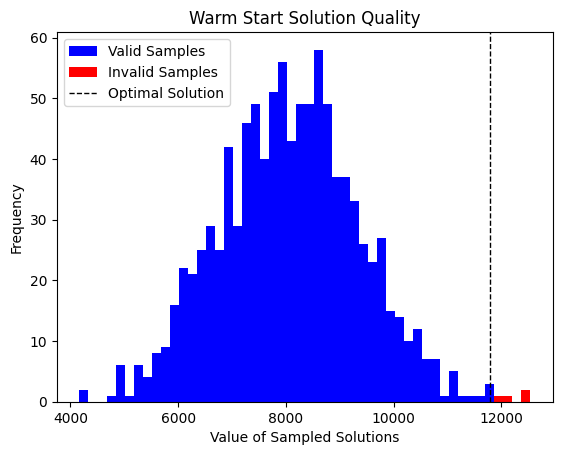

In [18]:
# We will pick k = 1000 since it gives a gives a good balance between the uniform and lazy greedy distributions.
k = 1000
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)

# Now sample from this distribtion
num_samples = 1000
samples = np.random.rand(num_samples, len(weights)) < smoothed_distribution
total_values = np.sum(samples * values, axis=1)
total_weights = np.sum(samples * weights, axis=1)
valid_samples = total_weights <= capacity

# Some nice to have statistics
probability_valid = np.sum(valid_samples) / num_samples
approxmation_ratio_of_valid = np.mean(total_values[valid_samples]) / optimal_value

# Lets make a histogram showing the total value of the samples
plt.figure()
plt.hist([total_values[valid_samples],total_values[~valid_samples]], bins=50, stacked = True, color=['blue','red'], label=['Valid Samples', 'Invalid Samples'])
plt.axvline(optimal_value, color='black', linestyle='dashed', linewidth=1, label='Optimal Solution')
plt.title('Warm Start Solution Quality')
plt.xlabel('Value of Sampled Solutions')
plt.ylabel('Frequency')
plt.legend()

print(f"Best valid solution value is: {np.max(total_values[valid_samples])}")
print(f"Worst invalid solution is: {np.min(total_values[~valid_samples])}")
print(f"Optimal solution value is: {optimal_value}")
print(f"Probability of valid samples: {probability_valid}")
print(f"Approximation ratio of valid samples: {approxmation_ratio_of_valid:.4f}")

The fundamental question we investigate next is whether we can improve performance of our solution by postprocessing the distribution with a quantum circuit. 

### Preparing Warm Start Distribution on a Quantum Computer 

In our quantum circuit, each qubit will represent one item in the knapsack. At the end of the circuit we measure all the qubits to produce a solution to the knapsack problem -- if a qubit is measured in the $\ket{1}$ state then the corresponding item will be in the napsack solution, and if is measured in the $\ket{0}$ state the corresponding item will be excluded from the soltuion. 

The first step then, is to initialize a quantum circuit with as many qubits as we have potential items to put in the knapsack. Then we prepare those qubits in a state whose measurement statistics match the warm start distribution described above on a quantum computer. We do this by rotating each qubit about the Y-axis to produce the state $\sqrt{1-p_i}\ket{0} + \sqrt{p_i}\ket{1}$ where $p_i$ is the probability the warm start distribution assignes to the $i$-th item. 

An important detail when we move on to constructing the xQAOA mixer will be the physical layout of our qubits. We order our qubits in terms of increasing ratio, so that adjacent qubits correspond to items with similar ratios of value/weight. When items have an identical ratio we use weight as a tiebreaker.

In [19]:
warm_start_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = warm_start_distribution[qubit_order]
ordered_weights = weights[qubit_order]
ordered_values = values[qubit_order]
ordered_ratios = ratios[qubit_order]

qc = QuantumCircuit(n)

def initialize_warm_start_distribution(quantum_circuit, distribution):
    """
    Initializes the quantum circuit with the given distribution.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to initialize.
        distribution (np.ndarray): The distribution to use for initialization.
    """
    for i in range(len(distribution)):
        angle = 2 * np.arcsin(np.sqrt(distribution[i]))
        quantum_circuit.ry(angle, i)  # Rotate qubit i by appropriate angle.
    
    qc.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)


Let's obtain the Gurobi solution for this new ordering

Knapsack Capacity: 11811.0
Total Value of optimal solution: 11795.129911249605
Total Weight of optimal solution: 11811
Runtime: 0.019179 seconds


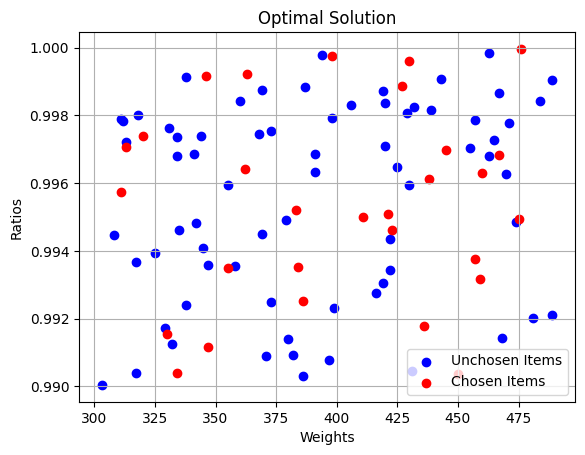

In [20]:
result_gurobi = gurobi_knapsack_solver(ordered_values, ordered_weights, capacity, verbose=False,
                                        time_limit=60,
                                        optimality_gap=1e-20,
                                        feasibility_tolerance=1e-9)

optimal_value = result_gurobi['total_value']
optimal_weight = result_gurobi['total_weight']

print(f"Knapsack Capacity: {capacity}")
print(f"Total Value of optimal solution: {result_gurobi['total_value']}")
print(f"Total Weight of optimal solution: {result_gurobi['total_weight']}")
print(f"Runtime: {result_gurobi['runtime']:.6f} seconds")

# Lets also plot the Gurobi solutions
soln_mask = np.array([c == '1' for c in result_gurobi['bitstring']], dtype=bool)
plt.figure()
plt.scatter(weights[~soln_mask], ratios[~soln_mask],  color='blue', marker='o', label='Unchosen Items')
plt.scatter(weights[soln_mask], ratios[soln_mask],  color='red', marker='o', label='Chosen Items')
plt.title('Optimal Solution')
plt.ylabel('Ratios')
plt.xlabel('Weights')
plt.legend()
plt.grid(True)
plt.show()

## The Copula Mixer

Now that we have initialized the warm start distribution on a quantum computer, we can use standard optimization techniques to try and shift the state towards an optimal (or near-optimal) knapsack solution. But if we try to apply standard QAOA techinques we encounter a problem. The knapsack problem is a constrained optimization problem, while QAOA is most naturally suited to *unconstrained* otpmization. It is always possible to add constraints, in the form of a penalty term, to the QAOA cost function then proceed like normal. But this approach complicates the cost function, and may (for inequality constraints as in the knapsack problem) also requires introducing slack variables which drive up the qubit count.  

An alternate approach to constrained optimization is to modify the QAOA mixer, so that the mixer dynamics naturally respect the constraints of the problem. But pursuing this approach in the case of the knapsack problem requires performing coherent addition between the qubits, which is out of scope for current quantum hardware. 

Here we pursure an alternate approach -- proposed in https://arxiv.org/abs/2108.08805 -- in which we modify the mixer in a way that we hope will approximately respect the knapsack constraints. This is less costly then the approach described in the previous paragraph, but still gives a way of partially incorporating constraints into the QAOA framework. 

The basic building block of this appraoch is a two-qubit mixer which we call the Copula mixer. This mixer takes as input variabels $\theta, p_1,$ and $p_2$, in addition to a parameter $\beta$ which controls the mixer strength as in standard QAOA. To explain this mixer, we first define the *Copula Distribution* $p_{cop}$ to be a distribution over two bits with: 

$$
\begin{align}
p_{cop}(0,0) &= (1 - p_1)(1-p_2) + \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(0,1) &= (1 - p_1)(p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,0) &= (p_1)(1-p_2) - \theta p_1 p_2(1 - p_1)(1-p_2) \\
p_{cop}(1,1) &= (p_1)(p_2) + \theta p_1 p_2(1 - p_1)(1-p_2)
\end{align}
$$

Straightforward computation shows that this distribution has single-bit marginal probabilities matching the proabilities $p_1$ and $p_2$ used in its definition. The $\theta$ parameter takes values in $[-1,1]$ and controls whether the two bits are correlated or anti-correlated in this distribution. When $\theta = -1$ bits are maximally anti-correlated, and $\theta = 1$ corresponds to bits being maximally correlated.  

Now we construct a unitary $R_{cop}$ satisfying $R_{cop}\ket{00} = \ket{p_{cop}}$ and define the mixer Hamiltoniaon $H_{cop} = -R_{cop}^\dagger (ZZ) R_{cop}$. Then the state $\ket{p_{cop}} = \sum_{x_1, x_2} \sqrt{p_{cop}(x_1,x_2)} \ket{x_1, x_2}$ is the ground state of the Hamiltonian with eigenvalue $-2$, and all other eigenstates have eigenvalue $\geq 0$. Finally, the Copula mixer in terms of $\beta$ is defined by 

$$
\begin{align}
U_{cop, \beta} = \exp(-i \beta H_{cop}).
\end{align}
$$

Note that setting $\beta = 0$ turns off the Copula mixer. Since the eigenvalues of $H_{cop}$ are multiples of two, **the mixer is period in $\beta$ with a periodicity of $\pi$**, i.e. we have $U_{cop, \ \beta} = U_{cop,\ \beta + \pi}$ for any $\beta$. 

In [21]:
def construct_cop(p_1, p_2, beta, theta = -1):
    """
    Constructs a two qubit copula mixer with the given parameters.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum on which we add the Copula mixer.
        p_1 (float): Probability p_1 in the definition of the copula mixer.
        p_2 (float): Probability p_2 in the definition of the copula mixer.
        beta (float): The strength of the copula mixer.
        theta (float): The theta parameter of the copula mixer, which controls whether qubits are correlated or anti-correlated. Should take values in [-1,1] and defaults to -1, which means maximum anticorrelation.

    Returns:
        QuantumCircuit: The quantum circuit with the copula mixer added.
    """

    # We first construct a rotation operator designed to rotate the |00> state to the |p_cop> state.
    rotation_circuit = QuantumCircuit(2)
    phi_1 = 2 * np.arcsin(np.sqrt(p_1))  
    p_2_given_1 = (p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2))/ p_1
    phi_2_given_1 = 2 * np.arcsin(np.sqrt(p_2_given_1))
    p_2_given_not1 = ((1- p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)) / (1 - p_1)
    phi_2_given_not1 = 2 * np.arcsin(np.sqrt(p_2_given_not1))

    rotation_circuit.ry(phi_1, 0)  # Rotate first qubit to the correct marginal distribution
    rotation_circuit.cry(phi_2_given_1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |1>
    rotation_circuit.x(0)  # Flip qubit 1
    rotation_circuit.cry(phi_2_given_not1, control_qubit=0, target_qubit=1)  # Create correct joint distribution if first qubit is |0>
    rotation_circuit.x(0)  # Undo flip

    copula_mixer = QuantumCircuit(2)
    copula_mixer.compose(rotation_circuit.inverse(), inplace=True) # rotate |p_cop> to |00>
    copula_mixer.barrier()  
    # In this rotated basis, the copula mixer is diagonal, so we can impliment with RZ gates.
    copula_mixer.rz(-2* beta, 0)  
    copula_mixer.rz(-2 *beta, 1)  
    copula_mixer.barrier()  
    copula_mixer.compose(rotation_circuit, inplace=True) # rotate |00> back to |p_cop>

    return copula_mixer
    

Now lets run some basic tests to verify the copula is working as intended. 

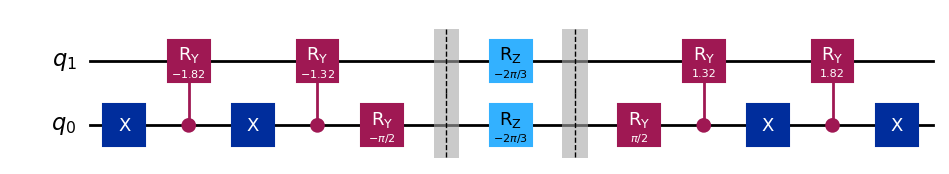

Eigenvalues of the copula mixer: 

Eigenvalue: -0.5000-0.8660j
Eigenvector: 0.5590+0.0000j |00>  + -0.4330+0.0000j |01> + -0.4330+0.0000j |10> + 0.5590+0.0000j |11>
Eigenvalue: -0.5000+0.8660j
Eigenvector: 0.4330+0.0000j |00>  + 0.5590+0.0000j |01> + 0.5590-0.0000j |10> + 0.4330+0.0000j |11>
Eigenvalue: 1.0000-0.0000j
Eigenvector: 0.0811-0.1836j |00>  + -0.6780+0.0000j |01> + 0.6780+0.0000j |10> + -0.0811+0.1836j |11>
Eigenvalue: 1.0000+0.0000j
Eigenvector: -0.5169-0.0000j |00>  + -0.4417-0.1941j |01> + 0.4417+0.1941j |10> + 0.5169+0.0000j |11>

We expect an eigenvector: 0.4330 |00> + 0.5590 |01> + 0.5590 |10> + 0.4330 |11>
with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = -0.5000+0.8660j


In [22]:
from qiskit.quantum_info import Operator 

# Test the copula mixer construction.
test_copula_mixer = construct_cop(0.5, 0.5, np.pi/3)

display(test_copula_mixer.draw('mpl', scale=1, idle_wires=False, fold=-1, reverse_bits=True))

# This unitary is small enough we can just check its eigenvectors and eigenvalues directly. 
cop_unitary = Operator(test_copula_mixer).data
eigenvalues, eigenvectors = np.linalg.eig(cop_unitary)

print("Eigenvalues of the copula mixer: \n")
for i, ev in enumerate(eigenvalues):
    print(f"Eigenvalue: {ev:.4f}")
    print(f"Eigenvector: {eigenvectors[0,i]:.4f} |00>  + {eigenvectors[1,i]:.4f} |01> + {eigenvectors[2,i]:.4f} |10> + {eigenvectors[3,i]:.4f} |11>")  


p_1 = 0.5
p_2 = 0.5
theta = -1
p_cop_00 = (1 - p_1) * (1 - p_2) + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_01 = (1 - p_1) * p_2 - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_10 = p_1 * (1 - p_2) - theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)
p_cop_11 = p_1 * p_2 + theta * p_1 * p_2 * (1 - p_1) * (1 - p_2)

print(f"\nWe expect an eigenvector: {np.sqrt(p_cop_00):.4f} |00> + {np.sqrt(p_cop_01):.4f} |01> + {np.sqrt(p_cop_10):.4f} |10> + {np.sqrt(p_cop_11):.4f} |11>")
print(f"with eigenvalue exp(2 i beta) = exp( 2 pi i / 3) = {np.exp(2j * np.pi / 3):.4f}")


Now we can construct the "ring" copula mixer proposed in https://arxiv.org/pdf/2108.08805. The idea is to visualize the qubits as lying in a ring, and to apply the two qubit copula mixer defined above between nearest neighbour terms on the ring. We get the probabilities $p_i$ and $p_j$ used in the defintion of each copula mixer from the warm start distribution we used to initialize our quantum state. 

This should have the effect of leaving the qubits with high ratios of value-to-weight as very likely in the knapsack, and the low ratio qubits as very likely excluded from the knapsack, but it will encourage mixing between the qubits with middling value. This mixing should anti-correlate nearby terms -- adding an item to the knapsack while removing an item with similar ratio -- and thus approximately preserve the overall knapsack weight.

In [25]:
def add_ring_copula(quantum_circuit, probability_dist, beta):
    """
    Constructs a ring copula mixer on the given quantum circuit.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the ring copula mixer.
        probability_dist (np.ndarray): The probability distribution to use for the copula mixer.
    """
    n = len(probability_dist)
    for i in range(1,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    for i in range(2,n,2):
        p_1 = probability_dist[i]
        p_2 = probability_dist[(i + 1) % n]
        copula_mixer = construct_cop(p_1, p_2, beta)
        quantum_circuit.compose(copula_mixer, qubits=[i, (i + 1) % n], inplace=True)

    quantum_circuit.barrier()  
    return quantum_circuit

To complete the setup for xQAOA we also need to define a cost function. Because we have encoded a (soft) version of our constraints into our mixer we leave constraints out of this cost function. But then it is particularly straightfoward -- we simply sum the values of each of the items included in the knapsack. 

As in standard QAOA we also multiple our cost function by a $\gamma$ parameter. Because we want this parameter to take values in $[0,2\pi]$, we will normalize all our values by the max possible value so the normalized values lie in $[0,1]$. 

In [26]:
def add_knapsack_cost_function(quantum_circuit, values, gamma):
    """
    Adds a cost function to the quantum circuit that sums the values of the items included in the knapsack.
    
    Args:
        quantum_circuit (QuantumCircuit): The quantum circuit to which we add the cost function.
        values (np.ndarray): The values of the items in the knapsack.
        gamma (float): The strength of the cost function.
    """

    max_value = np.max(values)
    n = len(values) 
    for i in range(n):
        quantum_circuit.p(gamma * values[i]/max_value, i)  # Apply RZ gate with angle proportional to value
    quantum_circuit.barrier()  # Add a barrier for clarity in the circuit diagram.
    return quantum_circuit

Finally, we can put this all together and visualize the circuit with the warm start initialization, one layer of the cost unitary, and one layer of the mixer. 

In [27]:
# Now lets plot a sample of our circuit with one layer of the ring copula mixer. 
# Picking arbitrary values of beta and gamma for now.
qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
qc = add_knapsack_cost_function(qc, ordered_values, 0.1)
qc = add_ring_copula(qc, qubit_ordered_distribution, np.pi/3)
#qc.draw("mpl",fold=-1, idle_wires=False)

Let's also define a class that will be useful for computing expectation values below.

Let's now use the lightcome estimator defined previously to compute the objective function achieved in expectation by the output distribution of a quantum circuit. We perform some sanity checks, then compute the performance of the depth one xQAOA mixer for some arbitrary values of $\gamma$ and $\beta$.

#### Using simulator to train variational parameters

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.primitives import EstimatorV2, SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit import Parameter
from scripts.utils.kp_utils import get_weight, get_value
from qiskit import transpile
service=QiskitRuntimeService(
    token='Z9qe9lMQ84EsXlMqND2LuND0vjTn9DkUkNqj9I1q4Khd',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/8f99915aec1d4742b2a6a9408b74a1af:5e49230c-df9f-4142-be46-96ac857249bd::',  # Replace with your actual instance
    channel="ibm_quantum_platform")
backend=service.backend('ibm_kingston')
optimization_level=3
pm = generate_preset_pass_manager(backend=backend, optimization_level = optimization_level)
nm = None
coupling_map = backend.configuration().coupling_map
basis_gates = backend.basis_gates

# initialize noisy simulator
estimator_mps = EstimatorV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                               })

sampler_mps = SamplerV2(
    options={"backend_options": {"method": "matrix_product_state",
                                 "noise_model": nm,
                                 "coupling_map":coupling_map,
                                 },
                                 })


def sampler_based_optimizer(qc, capacity, shots=10_000):
    qc = transpile(qc, basis_gates = backend.basis_gates)
    qc.measure_all()
    job = sampler_mps.run([(qc,)], shots=shots)
    sampler_result = job.result()
    sampled_counts = sampler_result[0].data.meas.get_counts() 
    shots = sum(sampled_counts.values())
    filtered_bitstrings= []
    filtered_cost_values = []
    for key in sampled_counts.keys():
        if get_weight(key[::-1], ordered_weights) <= capacity:
            filtered_bitstrings.append(key)
            filtered_cost_values.append(get_value(key[::-1], ordered_values) * sampled_counts[key]/shots)
        else: 
            continue
    filtered_distribution = {
        key: val / shots for key, val in sampled_counts.items() if key in filtered_bitstrings
    }
    filtered_exp_val = sum(filtered_cost_values)

    return filtered_distribution, filtered_exp_val 


from scipy.optimize import minimize

layers=1
max_iter=4
params=[]
shots=10_000

gammas = [Parameter(f"gamma_{i}") for i in range(layers)]
betas = [Parameter(f"beta_{i}") for i in range(layers)]

def cost_to_minimize(params:list, qc:QuantumCircuit):
    circ = qc.copy()
    circ.assign_parameters(params, inplace=True)
    _,cost = sampler_based_optimizer(circ, capacity=capacity, shots=shots)
    return -cost

def __optimization_loop__(qc, max_iter=max_iter):
    x_vals= []
    y_vals = []
    for i in range(max_iter):
        for k in range(max_iter):
            init_params = [i*np.pi/(max_iter-1), 2*k*np.pi/(max_iter-1)]
            result_lc = minimize(
            cost_to_minimize,
            init_params,
            args=qc,
            method="COBYLA",
            bounds=[(0, np.pi), (0, 2*np.pi)],
            tol=1e-2,
            )
            print(result_lc)
            y_vals.append(cost_to_minimize(list(result_lc.x),qc))
            x_vals.append((result_lc.x))
    
    min_params=x_vals[np.argmin(y_vals)]
    return min_params

qc = QuantumCircuit(n)
qc = initialize_warm_start_distribution(qc, qubit_ordered_distribution)
circuits_at_different_p=[]
with tqdm(total=layers) as pbar:
    for p in range(layers):
            qc = add_knapsack_cost_function(qc, ordered_values, gamma=gammas[p])
            qc = add_ring_copula(qc, qubit_ordered_distribution, beta=betas[p])
            min_params = __optimization_loop__(qc)
            params.append((min_params))
            qc.assign_parameters(min_params,inplace=True)
            circuits_at_different_p.append(qc.copy())
            pbar.update(1)
    

                              

Let's try a sampler based optimization. This is quicker than the estimator based optimization

In [28]:
print(f'Optimal parameters at different values of p: {params}')

Optimal parameters at different values of p: [array([1.98339732, 0.3556137 ]), array([3.13749604, 3.10194717]), array([8.55789996e-19, 3.02189510e+00]), array([3.14159265, 5.8975402 ]), array([3.14159265, 1.244375  ])]


Recalculating the distribution from xQAOA using the sampler based optimizer defined above

In [81]:
def compute_approximate_ratio(dict_bit_values, value_opt):
    # Compute the approximate ratio
    total = 0
    for values, counts in dict_bit_values.items():
        total += values * counts

    # sum all the counts in the histogram of valid solutions
    total_valid_shots = sum(dict_bit_values.values())
    aprox_ratio = total / (total_valid_shots * value_opt)

    return aprox_ratio
def convert_bitstring_to_values_new(counts, v, w, c):
    dict_bit_values_valid = {}
    dict_bit_values_invalid = {}

    for bitstring, count in tqdm(counts.items(), desc="Processing bitstrings", total=len(counts)):
        value = get_value(bitstring, v)
        if get_weight(bitstring, w) <= c:
            dict_bit_values_valid[value] = dict_bit_values_valid.get(value, 0) + count
        else:
            dict_bit_values_invalid[value] = dict_bit_values_invalid.get(value, 0) + count

    if not dict_bit_values_valid:
        print("No valid solutions found!")

    return dict_bit_values_valid, dict_bit_values_invalid

In [ ]:
from itertools import islice
dict_bit_values_at_different_p  = {}
pubs = []
shots = 100000

for circ in circuits_at_different_p:
    xp_circ = pm.run(circ)
    xp_circ.measure_active()
    pubs.append(xp_circ)

job = sampler_mps.run(pubs, shots=shots)   
for i in range(layers):
    counts_bin_qc = job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]


    dict_bit_values_lc_valid, dict_bit_values_lc_invalid = convert_bitstring_to_values_new(counts_bin_qc_rev, values, weights, capacity,
                                            )

    sorted_dict_valid_lc= dict(sorted(dict_bit_values_lc_valid.items(), key=lambda item: item[0], reverse=True))
    sorted_dict_invalid_lc= dict(sorted(dict_bit_values_lc_invalid.items(), key=lambda item: item[0], reverse=True))
    best_value_lc= max(sorted_dict_valid_lc.keys())
    best_count_lc= sorted_dict_valid_lc[best_value_lc]
    print(f"Best value: {best_value_lc}")
    nn=sum(dict_bit_values_lc_valid.values())
    print(nn/100000)
    approx_ratio = compute_approximate_ratio(dict(islice(sorted_dict_valid_lc.items(), nn)), optimal_value)

    print(f'Approximate ratio: {approx_ratio}')


Processing bitstrings: 100%|██████████| 100000/100000 [00:04<00:00, 21341.81it/s]


Best value: 11762.262867508227
0.95539
Approximate ratio: 0.8252587094838127


### warm start

In [106]:
from itertools import islice
shots=100000
filter_sols = False
warm_start_counts = defaultdict(int)
smoothed_distribution = construct_smoothed_lazy_greedy_distribution(weights, values, capacity, k)
qubit_order = np.lexsort((-weights, -ratios))

qubit_ordered_distribution = smoothed_distribution [qubit_order]
for _ in range(shots):
    bitstring = ''.join(str(int(np.random.random() < pi)) for pi in qubit_ordered_distribution)
    warm_start_counts[bitstring] += 1

dict_bit_values_ws_valid, dict_bit_values_ws_invalid = convert_bitstring_to_values_new(warm_start_counts, values, weights, capacity
                                                  )
sorted_dict_valid_ws= dict(sorted(dict_bit_values_ws_valid.items(), key=lambda item: item[0], reverse=True))

best_value_ws= max(sorted_dict_valid_ws.keys())
best_count_ws= sorted_dict_valid_ws[best_value_ws]
print(f"Best WS value: {best_value_ws}")
# Compute the probability of sucess
p_sucess_ws= probabilty_success(dict_bit_values_ws_valid, optimal_value)
number_of_valid_QAOA=sum(dict_bit_values_lc_valid.values())
print("ratio_of_valid_samples",sum(dict_bit_values_ws_valid.values())/100000)
approx_ratio_ws = compute_approximate_ratio(dict(islice(sorted_dict_valid_ws.items(), number_of_valid_QAOA)), optimal_value)
print(f"Best WS value: {max(dict_bit_values_ws_valid.keys())}")
print(f"WS approx ratio {approx_ratio_ws}")


0.997638520106743


Processing bitstrings: 100%|██████████| 100000/100000 [00:02<00:00, 35388.88it/s]


Best WS value: 11761.749744861234
ratio_of_valid_samples 0.9978
Best WS value: 11761.749744861234
WS approx ratio 0.7280975001684105


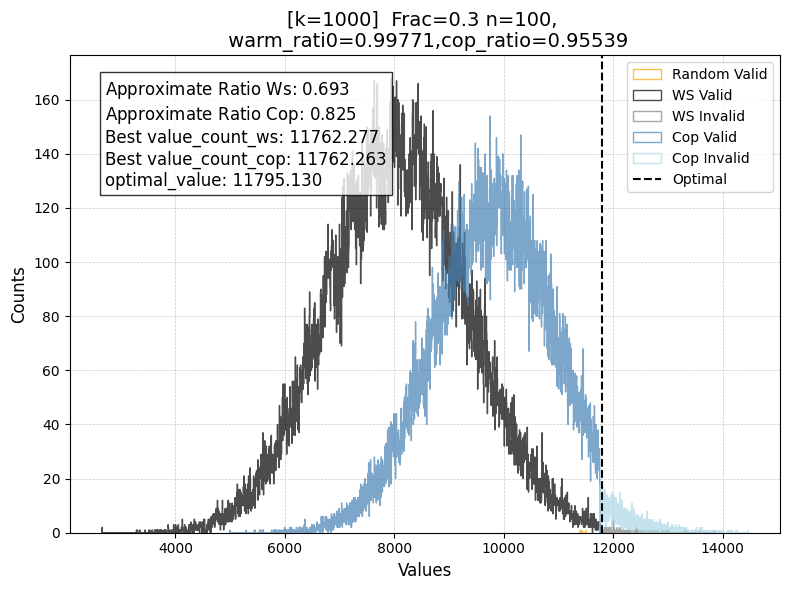

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '[k=1000]  Frac=0.3 n=100, \n warm_rati0=0.99771,cop_ratio=0.95539'}, xlabel='Values', ylabel='Counts'>)

In [ ]:
from scripts.utils.visualize import plot_multiple_distributions


data_dict = {
    f"Random Valid": dict_bit_values_random_valid,
    f"Random Invalid": [],
    f"WS Valid": dict_bit_values_ws_valid,
    f"WS Invalid": dict_bit_values_ws_invalid,
    f"Cop Valid": dict_bit_values_lc_valid,
    f"Cop Invalid": dict_bit_values_lc_invalid,
}

colors = {}
for label in data_dict.keys():
    if "Valid" in label:
        if "Random" in label:
            colors[label] = "orange"
        elif "WS" in label:
            colors[label] = "black"
        elif "Cop" in label:
            colors[label] = "steelblue"
    else:  # Invalid
        if "Random" in label:
            colors[label] = "lightsalmon"
        elif "WS" in label:
            colors[label] = "gray"
        elif "Cop" in label:
            colors[label] = "lightblue"
# Custom colors
# colors = {
#     f"Random_valid: Apr={approx_ratio_random:.2f}": "orange",
#     f"Random_invalid: Apr={approx_ratio_random:.2f}": "lightsalmon",
#     f"WS_valid: Apr={approx_ratio_ws:.3f}": 'black',
#     f"WS_invalid: Apr={approx_ratio_ws:.3f}": 'gray',
#     f"Cop_valid p=1: Apr={approx_ratio:.3f}": "steelblue",
#     f"Cop_invalid p=1: Apr={approx_ratio:.3f}": "lightblue",
# }
# Annotations
annotations = {
    r"$\mathrm{Approximate\ Ratio\ Ws}$": approx_ratio_ws,
    r"$\mathrm{Approximate\ Ratio\ Cop}$": approx_ratio,
    "Best value_count_ws": best_value_ws,
    "Best value_count_cop": best_value_lc,
    "optimal_value": optimal_value,
}


plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=2000,
    log=False,
    annotations=annotations,
    figsize=(8, 6),
    title=f"[k={k}]  Frac={frac} n={n}, \n warm_rati0={sum(dict_bit_values_ws_valid.values())/shots},cop_ratio={sum(dict_bit_values_lc_valid.values())/shots}",
    )



### Results on HW

In [ ]:
from qiskit_ibm_runtime import Session, SamplerOptions, QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler_options = SamplerOptions()
service=QiskitRuntimeService(
    token='Z9qe9lMQ84EsXlMqND2LuND0vjTn9DkUkNqj9I1q4Khd',
    instance='crn:v1:bluemix:public:quantum-computing:us-east:a/8f99915aec1d4742b2a6a9408b74a1af:5e49230c-df9f-4142-be46-96ac857249bd::',  # Replace with your actual instance
    channel="ibm_quantum_platform")
backend=service.backend('ibm_kingston')
optimization_level=3
pm = generate_preset_pass_manager(backend=backend, optimization_level = optimization_level)
dict_bit_values_at_different_p  = {}
pubs = []
shots = 100000

for circ in circuits_at_different_p:
    xp_circ = pm.run(circ)
    xp_circ.measure_active()
    pubs.append(xp_circ)

In [ ]:
with Session(backend=backend) as session:


    sampler_options.dynamical_decoupling.enable = True
    sampler_options.dynamical_decoupling.sequence_type = "XpXm"
    sampler_options.twirling.enable_measure = True
    sampler = Sampler(mode=session, options=sampler_options)

    job = sampler.run([pubs[0]], shots=shots)

In [ ]:
from itertools import islice
dict_bit_values_at_different_p  = {}
pubs = []
shots = 100000

for circ in circuits_at_different_p:
    xp_circ = pm.run(circ)
    xp_circ.measure_active()
    pubs.append(xp_circ)

job = sampler_mps.run(pubs, shots=shots)   
for i in range(layers):
    counts_bin_qc = job.result()[i].data.meas.get_counts()

    counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
    for key in counts_bin_qc.keys():
        reversed_key = key[::-1]
        counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]


    dict_bit_values_lc_valid, dict_bit_values_lc_invalid = convert_bitstring_to_values_new(counts_bin_qc_rev, values, weights, capacity,
                                            )

    sorted_dict_valid_lc= dict(sorted(dict_bit_values_lc_valid.items(), key=lambda item: item[0], reverse=True))
    sorted_dict_invalid_lc= dict(sorted(dict_bit_values_lc_invalid.items(), key=lambda item: item[0], reverse=True))
    best_value_lc= max(sorted_dict_valid_lc.keys())
    best_count_lc= sorted_dict_valid_lc[best_value_lc]
    print(f"Best value: {best_value_lc}")
    nn=sum(dict_bit_values_lc_valid.values())
    print(nn/100000)
    approx_ratio = compute_approximate_ratio(dict(islice(sorted_dict_valid_lc.items(), nn)), optimal_value)

    print(f'Approximate ratio: {approx_ratio}')


In [105]:
 for i in range(1):
        counts_bin_qc = job.result()[i].data.meas.get_counts()

        counts_bin_qc_rev = {}  # reverse bitstrings to account for little endian notation
        for key in counts_bin_qc.keys():
            reversed_key = key[::-1]
            counts_bin_qc_rev[reversed_key] = counts_bin_qc[key]

        dict_bit_values_lc_valid, dict_bit_values_lc_invalid = convert_bitstring_to_values_new(counts_bin_qc_rev, values, weights, capacity,
                                            )

        sorted_dict_valid_lc= dict(sorted(dict_bit_values_lc_valid.items(), key=lambda item: item[0], reverse=True))
        sorted_dict_invalid_lc= dict(sorted(dict_bit_values_lc_invalid.items(), key=lambda item: item[0], reverse=True))
        best_value_lc= max(sorted_dict_valid_lc.keys())
        best_count_lc= sorted_dict_valid_lc[best_value_lc]
        print(f"Best value: {best_value_lc}")
        nn=sum(dict_bit_values_lc_valid.values())
        print(nn/100000)
        approx_ratio = compute_approximate_ratio(dict(islice(sorted_dict_valid_lc.items(), nn)), optimal_value)

        print(f'Approximate ratio: {approx_ratio}')

Processing bitstrings: 100%|██████████| 100000/100000 [00:08<00:00, 12322.95it/s]


Best value: 11765.253764155343
0.75175
Approximate ratio: 0.8740853659419825


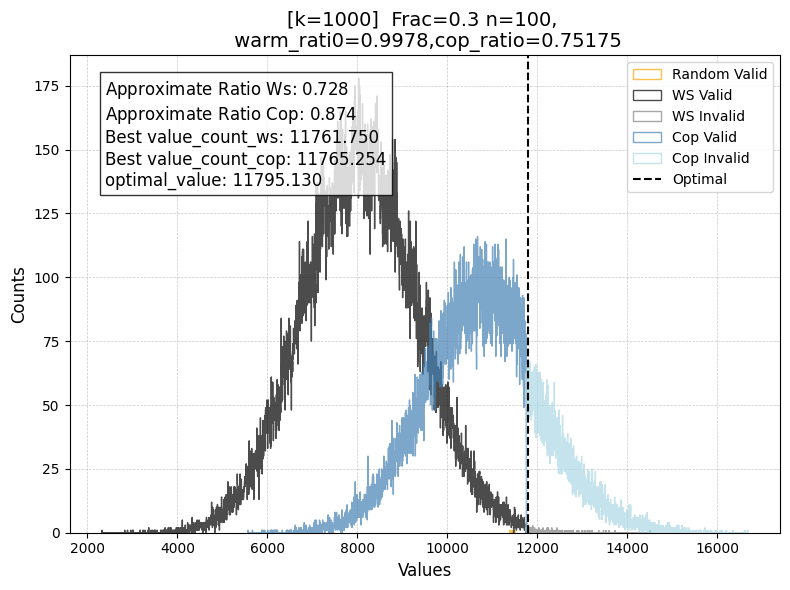

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': '[k=1000]  Frac=0.3 n=100, \n warm_rati0=0.9978,cop_ratio=0.75175'}, xlabel='Values', ylabel='Counts'>)

In [109]:
from scripts.utils.visualize import plot_multiple_distributions

# data_dict = {
#     f"Random: Apr={approx_ratio_random:.2f}": dict_bit_values_random_valid,
#     f"Random: Apr={approx_ratio_random:.2f}": dict_bit_values_random_invalid,
#    f"WS: Apr={approx_ratio_ws:.3f}": dict_bit_values_ws_valid,
#    f"WS: Apr={approx_ratio_ws:.3f}": dict_bit_values_ws_invalid,
#    f"Cop p=1: Apr={approx_ratio:.3f}": dict_bit_values_lc_valid,
#     f"Cop p=1: Apr={approx_ratio:.3f}": dict_bit_values_lc_invalid,

# }

data_dict = {
    f"Random Valid": dict_bit_values_random_valid,
    f"Random Invalid": [],
    f"WS Valid": dict_bit_values_ws_valid,
    f"WS Invalid": dict_bit_values_ws_invalid,
    f"Cop Valid": dict_bit_values_lc_valid,
    f"Cop Invalid": dict_bit_values_lc_invalid,
}

colors = {}
for label in data_dict.keys():
    if "Valid" in label:
        if "Random" in label:
            colors[label] = "orange"
        elif "WS" in label:
            colors[label] = "black"
        elif "Cop" in label:
            colors[label] = "steelblue"
    else:  # Invalid
        if "Random" in label:
            colors[label] = "lightsalmon"
        elif "WS" in label:
            colors[label] = "gray"
        elif "Cop" in label:
            colors[label] = "lightblue"
# Custom colors
# colors = {
#     f"Random_valid: Apr={approx_ratio_random:.2f}": "orange",
#     f"Random_invalid: Apr={approx_ratio_random:.2f}": "lightsalmon",
#     f"WS_valid: Apr={approx_ratio_ws:.3f}": 'black',
#     f"WS_invalid: Apr={approx_ratio_ws:.3f}": 'gray',
#     f"Cop_valid p=1: Apr={approx_ratio:.3f}": "steelblue",
#     f"Cop_invalid p=1: Apr={approx_ratio:.3f}": "lightblue",
# }
# Annotations
annotations = {
    r"$\mathrm{Approximate\ Ratio\ Ws}$": approx_ratio_ws,
    r"$\mathrm{Approximate\ Ratio\ Cop}$": approx_ratio,
    "Best value_count_ws": best_value_ws,
    "Best value_count_cop": best_value_lc,
    "optimal_value": optimal_value,
}


plot_multiple_distributions(
    data_dict=data_dict,
    min_cost=optimal_value,
    colors=colors,
    nb_bins=2000,
    log=False,
    annotations=annotations,
    figsize=(8, 6),
    title=f"[k={k}]  Frac={frac} n={n}, \n warm_rati0={sum(dict_bit_values_ws_valid.values())/shots},cop_ratio={sum(dict_bit_values_lc_valid.values())/shots}",
    )



In [108]:
job.job_id()

'd3hrgqi0uq0c73d7avc0'

### storing results

In [ ]:
import h5py
import json
import numpy as np

def save_knapsack(filename, values, weights, frac, job_ids):
    """Save knapsack arrays and job IDs to one HDF5 file."""
    with h5py.File(filename, "w") as f:
        f.create_dataset("values", data=values)
        f.create_dataset("weights", data=weights)
        f.create_dataset("frac", data=frac)
        f.attrs["job_ids"] = json.dumps(job_ids)




In [ ]:
def load_knapsack(filename):
    """Load knapsack arrays and job IDs from one HDF5 file."""
    with h5py.File(filename, "r") as f:
        values = f["values"][:]
        weights = f["weights"][:]
        frac = f["frac"][:]
        job_ids = json.loads(f.attrs["job_ids"])
    return values, weights, frac, job_ids